In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [2]:
class Encode(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super(Encode, self).__init__()
        self.encode1 = nn.Linear(input_shape, 100, bias=False)
        self.encode2 = nn.Linear(100, output_shape, bias=False)
    def forward(self, x: torch.Tensor):
        x = self.encode1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.encode2(x)
        return x

class Decode(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super(Decode, self).__init__()
        self.decode1 = nn.Linear(input_shape, 100, bias=False)
        self.decode2 = nn.Linear(100, output_shape, bias=False)
    def forward(self, x: torch.Tensor):
        x = self.decode1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.decode2(x)
        return x
    

In [3]:
Losses = []
trues = []
falses = []

In [4]:
losses = []
encode = Encode(175, 20).to(device)
decode = Decode(20, 175).to(device)
params = list(encode.parameters()) + list(decode.parameters())
optimizer = optim.Adam(params, lr=0.01)

clip = 1
torch.nn.utils.clip_grad_norm_(params, clip, norm_type=2, error_if_nonfinite=False)


criterion = nn.MSELoss().cuda() if torch.cuda.is_available() else nn.MSELoss()
for epoch in range(1000):
    if (epoch > 500) and (losses[-1] == losses[-2]) and (losses[-2] == losses[-3]) and (losses[-3] == losses[-4]) and (losses[-4] == losses[-5]):
        break
    for i in range(1, 90):
        optimizer.zero_grad()
        label = torch.load('/home/ocr/teluguOCR/Dataset/Batch_Label_Tensors/Label' + str(i) + '.pt').to(device)
        encoded = encode(label)
        reconstructed = decode(encoded)
        loss = criterion(reconstructed, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    if(epoch%10 == 0):
        print('Epoch: ', epoch, 'Loss: ', loss.item())
Losses.append(losses)
torch.save(encode.state_dict(), '/home/ocr/teluguOCR/Models/Encode_no_act' + str(20) + '.pth')
torch.save(decode.state_dict(), '/home/ocr/teluguOCR/Models/Decode_no_act' + str(20) + '.pth')
false = 0
true = 0
for ind in range(1, 90):
    labels = torch.load('/home/ocr/teluguOCR/Dataset/Batch_Label_Tensors/Label' + str(ind) + '.pt').to(device)
    for i in range(labels.size(0)):
        label = labels[i]
        encoded = encode(label)
        reconstructed = decode(encoded)
        reconstructed = torch.round(reconstructed)
        if torch.equal(label, reconstructed):
            true += 1
        else:
            false += 1
print('Trues: ', true)
print('Flases: ', false)
trues.append(true)
falses.append(false)
del encode
del decode
del params
del optimizer
del criterion


/home/ocr/anaconda3/envs/teluguOCR/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch:  0 Loss:  0.00204263161867857
Epoch:  10 Loss:  0.000437266833614558
Epoch:  20 Loss:  0.00030512994271703064
Epoch:  30 Loss:  0.00020943056733813137
Epoch:  40 Loss:  0.00029503178666345775
Epoch:  50 Loss:  0.00021288866992108524
Epoch:  60 Loss:  0.00012142528430558741
Epoch:  70 Loss:  0.00025447309599258006
Epoch:  80 Loss:  0.00011007166904164478
Epoch:  90 Loss:  0.00013077064068056643
Epoch:  100 Loss:  0.0001537467906018719
Epoch:  110 Loss:  8.599599823355675e-05
Epoch:  120 Loss:  9.591328853275627e-05
Epoch:  130 Loss:  0.00013821962056681514
Epoch:  140 Loss:  0.00013060345372650772
Epoch:  150 Loss:  9.403921285411343e-05
Epoch:  160 Loss:  7.045492384349927e-05
Epoch:  170 Loss:  8.65713955136016e-05
Epoch:  180 Loss:  6.122837658040226e-05
Epoch:  190 Loss:  9.41416437854059e-05
Epoch:  200 Loss:  0.00018788353190757334
Epoch:  210 Loss:  7.257572724483907e-05
Epoch:  220 Loss:  0.0001371008693240583
Epoch:  230 Loss:  5.999718268867582e-05
Epoch:  240 Loss:  0.

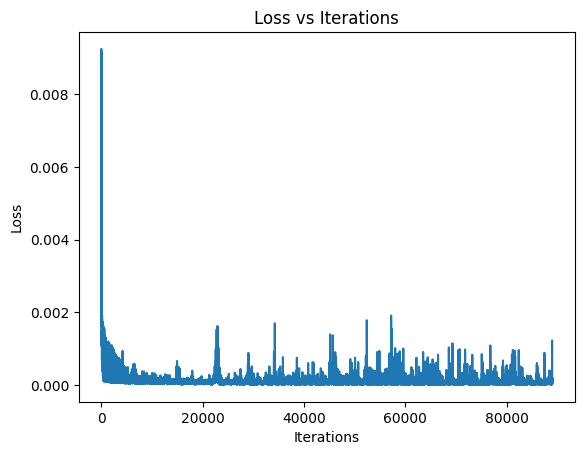

In [5]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.show()

In [6]:
# torch.save(encode.state_dict(), '/home/ocr/teluguOCR/Models/Encode_no_act' + str(40) + '.pth')
# torch.save(decode.state_dict(), '/home/ocr/teluguOCR/Models/Decode_no_act' + str(40) + '.pth')

encode = Encode(175, 40).to(device)
decode = Decode(40, 175).to(device)

encode.load_state_dict(torch.load('/home/ocr/teluguOCR/Models/Encode_no_act' + str(40) + '.pth'))
decode.load_state_dict(torch.load('/home/ocr/teluguOCR/Models/Decode_no_act' + str(40) + '.pth'))

encode.eval()
decode.eval()

false = 0
true = 0
for ind in range(1, 90):
    labels = torch.load('/home/ocr/teluguOCR/Dataset/Batch_Label_Tensors/Label' + str(ind) + '.pt').to(device)
    for i in range(labels.size(0)):
        label = labels[i]
        # label[label == 1] = 2e5
        encoded = encode(label)
        reconstructed = decode(encoded)
        # reconstructed = torch.sigmoid(reconstructed)
        reconstructed = torch.round(reconstructed)
        # reconstructed[reconstructed < 1e5] = 0
        # reconstructed[reconstructed >= 1e5] = 2e5
        if torch.equal(label, reconstructed):
            true += 1
        else:
            false += 1
print('Trues: ', true)
print('Flases: ', false)

Trues:  29083
Flases:  752


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


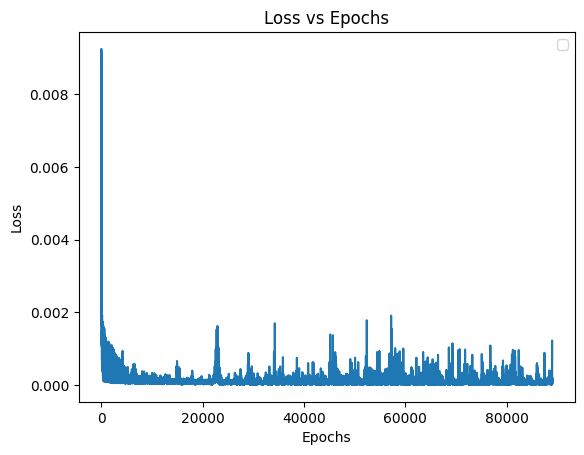

In [7]:
import matplotlib.pyplot as plt
plt.plot(Losses[i][:])
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
# plt.savefig('../Images/Encoding_sizes_Ann_MSELoss.png')
plt.show()

In [8]:
encode = Encode(175, 110).to(device)
decode = Decode(110, 175).to(device)
encode.load_state_dict(torch.load('/home/ocr/teluguOCR/Models/Encode110.pth'))
decode.load_state_dict(torch.load('/home/ocr/teluguOCR/Models/Decode110.pth'))
encode.eval()
decode.eval()

flases = 0
trues = 0
for ind in range(1, 90):
    labels = torch.load('/home/ocr/teluguOCR/Dataset/Batch_Label_Tensors/Label' + str(ind) + '.pt').to(device)
    for i in range(labels.size(0)):
        label = labels[i]
        encoded = encode(label)
        reconstructed = decode(encoded)
        reconstructed = torch.round(reconstructed)
        # reconstructed[reconstructed < 0.05] = 0
        # reconstructed[reconstructed >= 0.05] = 1
        if torch.equal(label, reconstructed):
            trues += 1
        else:
            flases += 1
print('Trues: ', trues)
print('Flases: ', flases)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ocr/teluguOCR/Models/Encode110.pth'

In [ ]:
# torch.save(encode.state_dict(), '/home/ocr/teluguOCR/encoder_175_to_100.pt')
# torch.save(decode.state_dict(), '/home/ocr/teluguOCR/decoder_100_to_175.pt')

In [ ]:
labels_path = '/home/ocr/teluguOCR/Dataset/Batch_Label_Tensors/Label'

for ind in range(1, 90):
    labels = torch.load(labels_path + str(ind) + '.pt').to(device)
    labels[labels == 1] = 1e5
    labels[labels == 0] = -1e5

In [22]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

criterion = nn.CTCLoss(blank= 0)

input = torch.zeros((3, 112))
input[0][1] = 1000

target = torch.tensor([1])

input = input.unsqueeze(1).log_softmax(2)
target = target.unsqueeze(0)

print(input.shape)
print(target.shape)

input_lengths = torch.full(size=(1,), fill_value=3, dtype=torch.long)
target_lengths = torch.full(size=(1,), fill_value=1, dtype=torch.long)

loss = criterion(input, target, input_lengths, target_lengths)
print(loss)

torch.Size([3, 1, 112])
torch.Size([1, 1])
tensor(8.3384)
